In [1]:
%matplotlib inline

from config import configs

import os
import io
import numpy as np
import matplotlib
import timeit
import random
import cv2
import deepdish as dd

import matplotlib.pyplot as plt

from pprint import pprint
from datetime import datetime
from pixor_targets import PIXORTargets
from skimage.transform import resize
from scipy.interpolate import griddata
from core.kitti import KITTI
from pixor_utils.model_utils import load_model, save_model
from data_utils.training_gen import TrainingGenerator
from data_utils.generator import Generator, KITTIGen
from tt import bev
from data_utils.generator import KITTIGen
from pixor_utils.post_processing import nms_bev
from test_utils.unittest import test_pc_encoder, test_target_encoder
from encoding_utils.pointcloud_encoder import OccupancyCuboidKITTI
from encoding_utils.voxelizer import BEVVoxelizer

In [2]:
DS_DIR = os.path.expanduser(configs['dataset_path'])

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = configs["gpu_id"]
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [3]:
# Point Cloud Encoder
INPUT_SHAPE = configs['input_shape']

# Training
BATCH_SIZE = configs['hyperparams']['batch_size']
LEARNING_RATE = configs['hyperparams']['lr']
EPOCHS = configs['hyperparams']['epochs']
NUM_THREADS = configs['hyperparams']['num_threads']
MAX_Q_SIZE = configs['hyperparams']['max_q_size']

In [4]:
kitti = KITTI(DS_DIR, configs['training_target'])

train_ids = kitti.get_ids('train')
val_ids = kitti.get_ids('val')
micro_ids = kitti.get_ids('micro')

In [5]:
print(len(train_ids) // 2)

1856


In [6]:
pc_encoder = OccupancyCuboidKITTI(0, 70, -40, 40, -1, 3, [0.1, 0.1, 0.4]) # 0.1, 0.1, 0.4
pc_encoder = BEVVoxelizer(n_x=448, n_y=512, n_z=32, side_range=(0,70), fwd_range=(-40,40), height_range=(-1, 3), filter_external=True)

In [7]:
target_encoder = PIXORTargets(shape=(128, 112), 
                              stats=dd.io.load('kitti_stats/new_stats.h5'),
                              P_WIDTH=70, P_HEIGHT=80, P_DEPTH=4, 
                              subsampling_factor=(0.75, 1.25))

In [8]:
train_gen = KITTIGen(kitti, train_ids, BATCH_SIZE, pc_encoder=pc_encoder, target_encoder=target_encoder)

In [9]:
# for batch in train_gen:
# #     start = timeit.default_timer()
#     bev, rgb_img, depth_map, intensity_map, height_map, (obj, geo) = batch
# #     print('took {}'.format(timeit.default_timer() - start))
# #     print('bev.shape          ', bev.shape)
# #     print('rgb_img.shape      ', rgb_img.shape)
# #     print('depth_map.shape    ', depth_map.shape)
# #     print('intensity_map.shape', intensity_map.shape)
# #     print('height_map.shape   ', height_map.shape)
# #     print('obj.shape          ', obj.shape)
# #     print('geo.shape          ', geo.shape)
# #     print('------------------------')

In [76]:
cur_idx = train_ids[159]

In [77]:
boxes = kitti.get_boxes_3D(cur_idx)
encoded = target_encoder.encode(boxes)

In [78]:
outmap = np.squeeze(np.concatenate((encoded[0][:,:,0:1], encoded[1]), axis=-1))
outmap.shape

(112, 128, 11)

In [79]:
org_boxes = target_encoder.decode(outmap, 0.8)
nms  = nms_bev('dist', -2.5, max_boxes=20)
org_boxes = nms(org_boxes)
print(len(boxes), len(org_boxes))

4 4


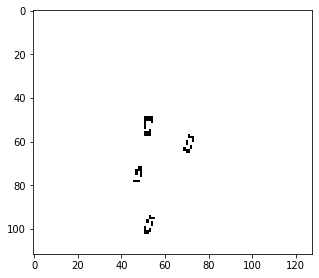

In [80]:
# plt.figure(figsize = (5,5))
# plt.imshow(np.squeeze(encoded[0][:,:,0]), cmap='gray')

plt.figure(figsize = (5,5))
plt.imshow(np.squeeze(encoded[0][:,:,1]), cmap='gray')

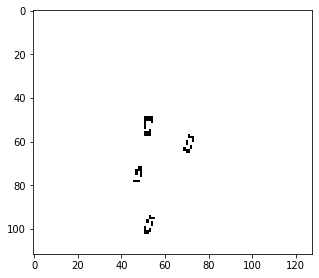

In [81]:
org_encoded = target_encoder.encode(org_boxes)
# plt.figure(figsize = (5,5))
# plt.imshow(np.squeeze(org_encoded[0][:,:,0]), cmap='gray')

plt.figure(figsize = (5,5))
plt.imshow(np.squeeze(org_encoded[0][:,:,1]), cmap='gray')

In [16]:
# cos, sin = [], []
# for id in train_ids:
#     boxes = kitti.get_boxes_3D(id)
#     for box in boxes:
#         cur_yaw = box.yaw
#         if cur_yaw < 0:
#             cur_yaw *= -1
#         cos.append(np.cos(cur_yaw))
#         sin.append(np.sin(cur_yaw))
# print('cos_mean', np.mean(cos), 'cos_std', np.std(cos))
# print('sin_mean', np.mean(sin), 'sin_std', np.std(sin))